In [1]:
library(mgcv)
library(ggplot2)
library(hash)
library(dplyr)
library(PerformanceAnalytics)
library(latex2exp)

Warning message:
“package ‘mgcv’ was built under R version 3.6.3”Loading required package: nlme
Warning message:
“package ‘nlme’ was built under R version 3.6.3”This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.
Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”hash-2.2.6.1 provided by Decision Patterns

Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘PerformanceAnalytics’ was built under R version 3.6.3”Loading required package: xts
Warning message:
“package ‘xts’ was built under R version 3.6.3”Loading required package: zoo
Warning message:
“package ‘zoo’ was built under R version 3.6.3”
Attaching package: ‘zoo’

The following objects are masked from

#### 그림을 여러 개를 그리기 위한 함수를 준비한다. 

In [2]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)


  par(mar=c(7, 0, 7, 0))
  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    numPlots = length(plots)
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols), byrow=T)
#                    ncol = ceiling(numPlots/cols), nrow = cols)
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

#### National Emergency Department Information System (NEDIS) database of strokes (I60/I61/I63) from 2015/01/01 to 2018/12/31

In [3]:
df = read.csv("../stroke_daily_time_series_input.csv")
head(df)

date,dailyI60_adm,dailyI60_onset,dailyI60_adm_F,dailyI60_adm_M,dailyI60_adm_Y,dailyI60_adm_O,dailyI61_adm,dailyI61_onset,dailyI61_adm_F,...,l4,l5,l6,h0,h1,h2,SO2_ppb,O3_ppb,NO2_ppb,hPam
2014-12-18,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,4.855750,20.429410,21.86265,71.59967
2014-12-19,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,6.269947,7.512732,37.60379,69.10067
2014-12-20,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,5.394098,16.025751,23.06029,59.87342
2014-12-21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,4.564461,17.791559,14.70581,62.34937
2014-12-22,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,5.259344,13.788850,23.84443,63.29635
2014-12-23,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,6.261307,9.503221,36.27112,65.44733


#### 분석에 사용할 대기오염물질들의 Lag 데이터와 그 외에 MERS 전염병 유행기간, day of week (dow), month of year (mon), 휴일유무(holiTrue), the lapse days from previous holiday (ldsph) 생산한다.

In [4]:
# lagging 0-7
for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
    for (interval in seq(1, 7, 1)) {
        var = paste(ap, interval, sep="l")
        df[var] <- lag(df[ap], interval, na.pad = TRUE)
    }
}

# leading 1
for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
    var = paste(ap, -1, sep="l")
    df[var] <- lead(df[ap], 1, na.pad = TRUE)
}

# renaming leading 1 rownames
for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
    var_from = paste(ap, "l-1", sep="")
    var_to = paste(ap, "lm1", sep="")
    names(df)[names(df) == var_from] <- var_to
}

categorical_vars <- c('MERS', 'dow', 'mon', 'holiTrue', 'ldsph')
df[,categorical_vars] <- lapply(df[,categorical_vars], factor)

colnames(df)

[1] "date"           "dailyI60_adm"   "dailyI60_onset" "dailyI60_adm_F"
  [5] "dailyI60_adm_M" "dailyI60_adm_Y" "dailyI60_adm_O" "dailyI61_adm"  
  [9] "dailyI61_onset" "dailyI61_adm_F" "dailyI61_adm_M" "dailyI61_adm_Y"
 [13] "dailyI61_adm_O" "dailyI63_adm"   "dailyI63_onset" "dailyI63_adm_F"
 [17] "dailyI63_adm_M" "dailyI63_adm_Y" "dailyI63_adm_O" "SO2"           
 [21] "CO"             "NO2"            "O3"             "PM10"          
 [25] "PM25"           "T"              "H"              "precip"        
 [29] "ws"             "hPa"            "T_DdiffT"       "MERS"          
 [33] "dow"            "mon"            "t"              "holiTrue"      
 [37] "ldsph"          "m1"             "m2"             "m3"            
 [41] "m4"             "m5"             "m6"             "m7"            
 [45] "m8"             "m9"             "m10"            "m11"           
 [49] "m12"            "w0"             "w1"             "w2"            
 [53] "w3"             "w4"             "w5"             "w6"            
 [57] "l0"             "l1"             "l2"             "l3"            
 [61] "l4"             "l5"             "l6"             "h0"            
 [65] "h1"             "h2"             "SO2_ppb"        "O3_ppb"        
 [69] "NO2_ppb"        "hPam"           "SO2l1"          "SO2l2"         
 [73] "SO2l3"          "SO2l4"          "SO2l5"          "SO2l6"         
 [77] "SO2l7"          "COl1"           "COl2"           "COl3"          
 [81] "COl4"           "COl5"           "COl6"           "COl7"          
 [85] "O3l1"           "O3l2"           "O3l3"           "O3l4"          
 [89] "O3l5"           "O3l6"           "O3l7"           "NO2l1"         
 [93] "NO2l2"          "NO2l3"          "NO2l4"          "NO2l5"         
 [97] "NO2l6"          "NO2l7"          "PM10l1"         "PM10l2"        
[101] "PM10l3"         "PM10l4"         "PM10l5"         "PM10l6"        
[105] "PM10l7"         "PM25l1"         "PM25l2"         "PM25l3"        
[109] "PM25l4"         "PM25l5"         "PM25l6"         "PM25l7"        
[113] "SO2lm1"         "COlm1"          "O3lm1"          "NO2lm1"        
[117] "PM10lm1"        "PM25lm1"

#### 대기오염물질 Lag 값을 구하기 위해서 연구기간 앞 뒤로 2주일 정도의 데이터를 붙였으나 outcome은 연구기간만 존재하므로 연구기간외에 기간이 분석에 들어갈 경우 그 기간의 outcome은 0이 처리된다.  이런 데이터는 noise로  poisson distribution이나 negative binomial distribution으로 Regression을 하면 overdispersion 할 가능성이 존재하기 때문에 가능한 깔끔하게 데이터를 정리한다. 

In [5]:
df$date <- as.Date(df$date, '%Y-%m-%d')
df <- subset(df, date >= as.Date('2015-01-01') & date <= as.Date('2018-12-31'))

#### Confidence interval을 구하기 위한 각 대기 오염물질들의 IQR을 결정

In [6]:
sapply(df[c('SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 
            'T', 'H', 'precip','ws', 'hPa', 'T_DdiffT')], quantile, prob=c(0.25, 0.75), na.rm=TRUE)
diff(sapply(df[c('SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'T', 'H', 'precip', 'ws', 'hPa', 'T_DdiffT')], quantile, prob=c(0.25, 0.75), na.rm=TRUE))
many_iqrs <-diff(sapply(df[c('SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'T', 'H', 'precip', 'ws', 'hPa', 'T_DdiffT')], quantile, prob=c(0.25, 0.75), na.rm=TRUE))

,SO2,CO,O3,NO2,PM10,PM25,T,H,precip,ws,hPa,T_DdiffT
25%,0.003377263,0.3738998,0.01985390,0.01512387,30.38040,16.26763,4.496465,57.05032,0.0004739269,1.501538,999.948,7.094787
75%,0.004581822,0.5395150,0.03521984,0.02533222,53.71585,31.66723,21.700500,76.52884,0.1805258896,2.263472,1012.179,11.104026


,SO2,CO,O3,NO2,PM10,PM25,T,H,precip,ws,hPa,T_DdiffT
75%,0.001204558,0.1656152,0.01536594,0.01020834,23.33545,15.3996,17.20404,19.47852,0.180052,0.7619342,12.23119,4.009239


#### IQR가 해쉬테이블에 저장

In [7]:
iqr <- hash() 
for (vars in c('SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
               'T', 'H', 'precip', 'ws', 'hPa', 'T_DdiffT')) {
    iqr[[vars]] <- many_iqrs[, vars]
}

### Association between I60 and 6 air pollutants
1. We should select control variables by univariable association
2. Generalized additive model of negative binomial with estimating hyperparameter, theta 

#### control vairable 들을 하나씩 넣어서 통계적 유의성을 검증한다. 

In [8]:
results <- data.frame()
cnt <- 1
for (var in c('T', 'H', 'precip', 'ws', 'hPa', 'T_DdiffT', 'MERS', 
              'dow', 'mon', 't', 'holiTrue', 'ldsph')) {
    if (is.factor(df[, var])) 
        formula <- as.formula(sprintf("dailyI60_adm ~ %s", var))
    else 
        formula <- as.formula(sprintf("dailyI60_adm ~ s(%s)", var))
            
    model <- gam(formula = formula, data=df, method="REML", family=nb())
    rho <- exp(coef(model)[var]*1)
    ci <- exp(confint.default(model, var)*1)
    #resultsI60[cnt, 1] <- y
    results[cnt, 1] <- var
    results[cnt, 2] <- confint.default(model)[2,1]
    results[cnt, 3] <- model$coefficients[2]
    results[cnt, 4] <- confint.default(model)[2,2]
    cnt <- cnt + 1
}

#### 통계적 유의성을 가지는 control variable 들을 확인한다. 

In [9]:
names(results)[names(results) == 'V1'] <- 'predictor'
names(results)[names(results) == 'V2'] <- 'lwr'
names(results)[names(results) == 'V3'] <- 'mean'
names(results)[names(results) == 'V4'] <- 'upr'

results['stats'] <- ifelse(results['lwr'] >= 0 & results['upr'] >= 0, '+', '')
results[results[,'stats']=='+', ]

,predictor,lwr,mean,upr,stats
4,ws,0.002823852,0.03659242,0.07036099,+
9,mon,0.005855389,0.06797150,0.13008761,+
12,ldsph,0.120645674,0.16401905,0.20739243,+


In [10]:
results['stats'] <- ifelse(results['lwr'] < 0 & results['upr'] < 0, '-', '')
results[results[,'stats']=='-', ]

,predictor,lwr,mean,upr,stats
5,hPa,-0.1383964,-0.07063296,-0.002869525,-
6,T_DdiffT,-0.1222009,-0.06319427,-0.004187688,-
7,MERS,-0.1619277,-0.09993967,-0.037951637,-
8,dow,-0.1246093,-0.07852681,-0.032444322,-
11,holiTrue,-0.1201707,-0.08207784,-0.043985002,-


#### Variance inflaction factor를 살펴보기 위해서 univariable 분석에서 유의한 것들의 상관관계를 살펴본다. PearsonR이 0.6 이상인 pair가 있는지 살펴보고 있다면 둘 중 더 outcome과 직접적인 연관성이 있어서 보이는 variable을 선택한다. 

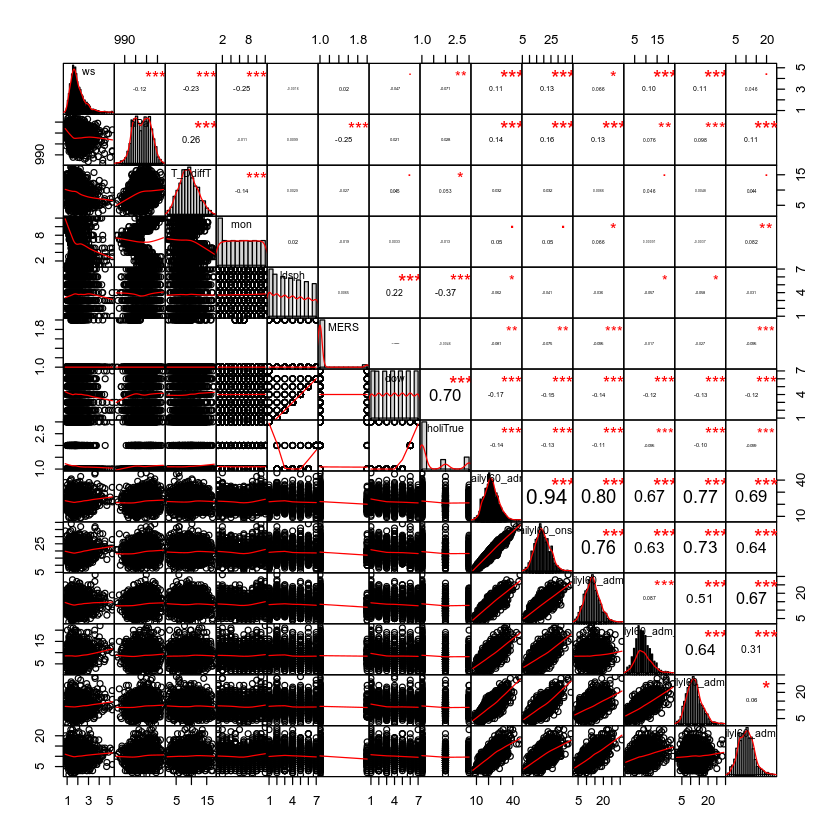

In [11]:
I60 <- df[, c('ws', 'hPa', 'T_DdiffT', 'mon', 'ldsph', 'MERS', 'dow', 'holiTrue',
             'dailyI60_adm', 'dailyI60_onset', 'dailyI60_adm_F', 
             'dailyI60_adm_M', 'dailyI60_adm_Y', 'dailyI60_adm_O')]
categorical_vars <- c('mon', 'ldsph', 'MERS', 'dow', 'holiTrue')
I60[,categorical_vars] <- lapply(I60[, categorical_vars], as.numeric)
chart.Correlation(I60, histogram=TRUE, pch=1, cex.cor.scale=0)

List of control variables for I60
 - 'ws', 'hPa', 'T_DdiffT', 'mon', 'ldsph', 'MERS', 'dow', 'holiTrue'

but, 
 - PearsonR(dow, holiTrue) = 0.7

We only include
 - 'ws', 'hPa', 'T_DdiffT', 'mon', 'ldsph', 'MERS', 'dow'

In [12]:
# model <- gam(dailyI60_adm ~ PM25 + s(ws) + s(hPa) + s(T_DdiffT) + MERS + mon + ldsph + dow, 
#              data = df, method = "REML", family=nb())
# summary(model)
# par(mfrow=c(2,1))
# plot(residuals(model), type="b")
# abline(h=0, lty=3)
# acf(residuals(model), lag=365)
# par(mfrow=c(2,4))
# plot(model, residuals=TRUE, pages=1, pch=1,shade=TRUE,all.terms=TRUE,
#     seWithMean = TRUE,shift=coef(model)[1], cex=0.5)
# gam.check(model)
# plot(model, select=2, shade = TRUE, scale = 0, seWithMean = TRUE)

#### 6개의 outcome에 대해서 6가지 대기오염물질 하나씩 lag값을 -1 ~ 7까지 single pollutant 모델로 회귀분석을 한다

In [13]:
cnt <- 1
resultsI60 <- data.frame()
for (y in c('dailyI60_adm', 'dailyI60_onset', 'dailyI60_adm_F', 
             'dailyI60_adm_M', 'dailyI60_adm_Y', 'dailyI60_adm_O')) {
    for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
        for (interval in c("lm1", "", "l1", "l2", "l3", "l4", "l5", "l6", "l7")) {
            if (is.na(interval) || interval == '') {
                var = ap
            }
            else {
                var = paste(ap, interval, sep="")
            }
        
            formula <- as.formula(sprintf("%s ~ %s + s(ws) + s(hPa) + s(T_DdiffT) + 
                                                MERS + mon + ldsph + dow", y, var))
            model <- gam(formula = formula, data=df, method="REML", family=nb())
            
            
            rho <- exp(coef(model)[var]*1)
            ci <- exp(confint.default(model, var)*1)
            resultsI60[cnt, 1] <- y
            resultsI60[cnt, 2] <- var
            resultsI60[cnt, 3] <- exp(confint.default(model)[2,1]*iqr[[ap]])
            resultsI60[cnt, 4] <- exp(model$coefficients[2]*iqr[[ap]])
            resultsI60[cnt, 5] <- exp(confint.default(model)[2,2]*iqr[[ap]])
            cnt <- cnt + 1
        }
    }
}

In [14]:
names(resultsI60)[names(resultsI60) == 'V1'] <- 'Outcome'
names(resultsI60)[names(resultsI60) == 'V2'] <- 'predictor'
names(resultsI60)[names(resultsI60) == 'V3'] <- 'lwr'
names(resultsI60)[names(resultsI60) == 'V4'] <- 'mean'
names(resultsI60)[names(resultsI60) == 'V5'] <- 'upr'

resultsI60['stats'] <- ifelse(resultsI60['lwr'] >= 1 & resultsI60['upr'] >= 1, '+', '')
resultsI60[resultsI60[,'stats']=='+', ]

,Outcome,predictor,lwr,mean,upr,stats
25,dailyI60_adm,O3l5,1.000465,1.030552,1.061544,+
26,dailyI60_adm,O3l6,1.014398,1.044730,1.075969,+
27,dailyI60_adm,O3l7,1.005501,1.035420,1.066229,+
80,dailyI60_onset,O3l6,1.010106,1.041493,1.073855,+
134,dailyI60_adm_F,O3l6,1.021155,1.059892,1.100098,+
135,dailyI60_adm_F,O3l7,1.002564,1.040439,1.079745,+
208,dailyI60_adm_M,PM25lm1,1.000406,1.033532,1.067754,+
226,dailyI60_adm_Y,COlm1,1.000692,1.035839,1.072220,+
296,dailyI60_adm_O,O3l6,1.008409,1.052714,1.098964,+


In [15]:
resultsI60['stats'] <- ifelse(resultsI60['lwr'] < 1 & resultsI60['upr'] < 1, '-', '')
resultsI60[resultsI60[,'stats']=='-', ]

,Outcome,predictor,lwr,mean,upr,stats
2,dailyI60_adm,SO2,0.9497638,0.9733701,0.9975631,-
3,dailyI60_adm,SO2l1,0.9476234,0.9672532,0.9872896,-
11,dailyI60_adm,CO,0.9394022,0.9669407,0.9952865,-
12,dailyI60_adm,COl1,0.9524068,0.9737939,0.9956614,-
29,dailyI60_adm,NO2,0.9238986,0.9608251,0.9992276,-
30,dailyI60_adm,NO2l1,0.9417696,0.9636284,0.9859945,-
47,dailyI60_adm,PM25,0.9567614,0.9768281,0.9973157,-
56,dailyI60_onset,SO2,0.9463103,0.9707488,0.9958183,-
57,dailyI60_onset,SO2l1,0.9473525,0.9677145,0.9885142,-
61,dailyI60_onset,SO2l5,0.9580088,0.9775463,0.9974823,-


#### 6개의 대기오염물질들의 confidence interval을 2x3 패널에 하나씩 그린다. 

In [18]:
cnt_outcome <- 1
num_panel <- c('a', 'b', 'c', 'd', 'e', 'f')
outcome_names <- c('Nation-wide I60 daily E.R. adm.', 'Nation-wide I60 daily E.R. onset',
                   'Female I60 daily E.R. adm.', 'Male I60 daily E.R. adm.', 
                   '60– I60 daily E.R. adm.', '60+= I60 daily E.R. adm.')

ap_str <- c("$SO_2$", "$CO$", "$O_3$", "$NO_2$", "$PM_{10}$", "$PM_{2.5}$")
for (y in c('dailyI60_adm', 'dailyI60_onset', 'dailyI60_adm_F', 
             'dailyI60_adm_M', 'dailyI60_adm_Y', 'dailyI60_adm_O')) {

    plt_list = list()
    cnt_ap <- 1
    for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
        tmp <- resultsI60[resultsI60['Outcome'] == y, ]
        df_ap <- tmp[grep(ap, tmp$predictor), ]
        df_ap['Lag'] <- c('L–1', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7')
        plt <- ggplot(df_ap, aes(x = Lag, y = mean)) +
               geom_point(show.legend=T, size=0.7, 
                         position=position_dodge(width=0.3)) +
               geom_errorbar(data=df_ap, size=0.3, 
                            aes(ymin=lwr, ymax=upr, width=.3),
                               position=position_dodge(width=0.3)) +
               geom_hline(yintercept=1, linetype="longdash", size=0.3) +
               ggtitle(TeX(paste(paste(num_panel[[cnt_ap]], 
                                   outcome_names[[cnt_outcome]], sep=". "), 
                             ap_str[[cnt_ap]], sep=" ~ ")))+
               ylab("Excess rate")+
               scale_x_discrete(name=TeX(ap_str[[cnt_ap]])) +
               theme(plot.title=element_text(size=9, face="bold"),
                    axis.title.x=element_text(size=9, color="black"),
                    axis.title.y=element_text(size=9, color="black"),
                    axis.text.x=element_text(size=9, color="black"),
                    axis.text.y=element_text(size=9, color="black"),
                    legend.text = element_text(size=9),
                    legend.key=element_rect(fill=NA),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    axis.line = element_line(size=0.4, colour = "black"))
         plt_list[[cnt_ap]] <- plt            
         cnt_ap <- cnt_ap + 1
    }
    
    ggsave(paste(gsub(" ","_", outcome_names[[cnt_outcome]]), "png", sep="."),
           multiplot(plt_list[[1]], plt_list[[2]], plt_list[[3]], 
           plt_list[[4]], plt_list[[5]], plt_list[[6]], cols=2))
    cnt_outcome <- cnt_outcome + 1
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### Association between I61 and 6 air pollutants
1. We should select control variables by univariable association
2. Generalized additive model of negative binomial with estimating hyperparameter, theta 

In [19]:
results <- data.frame()
cnt <- 1
for (var in c('T', 'H', 'precip', 'ws', 'hPa', 'T_DdiffT', 'MERS', 
              'dow', 'mon', 't', 'holiTrue', 'ldsph')) {
    if (is.factor(df[, var])) 
        formula <- as.formula(sprintf("dailyI61_adm ~ %s", var))
    else 
        formula <- as.formula(sprintf("dailyI61_adm ~ s(%s)", var))
            
    model <- gam(formula = formula, data=df, method="REML", family=nb())
    rho <- exp(coef(model)[var]*1)
    ci <- exp(confint.default(model, var)*1)
    #resultsI60[cnt, 1] <- y
    results[cnt, 1] <- var
    results[cnt, 2] <- confint.default(model)[2,1]
    results[cnt, 3] <- model$coefficients[2]
    results[cnt, 4] <- confint.default(model)[2,2]
    cnt <- cnt + 1
}

In [20]:
names(results)[names(results) == 'V1'] <- 'predictor'
names(results)[names(results) == 'V2'] <- 'lwr'
names(results)[names(results) == 'V3'] <- 'mean'
names(results)[names(results) == 'V4'] <- 'upr'

results['stats'] <- ifelse(results['lwr'] >= 0 & results['upr'] >= 0, '+', '')
results[results[,'stats'] == '+', ]

,predictor,lwr,mean,upr,stats
4,ws,0.03071875,0.07026865,0.1098185,+
10,t,0.34233345,0.44396594,0.5455984,+
12,ldsph,0.16881271,0.20781977,0.2468268,+


In [21]:
results['stats'] <- ifelse(results['lwr'] < 0 & results['upr'] < 0, '-', '')
results[results[,'stats'] == '-', ]

,predictor,lwr,mean,upr,stats
1,T,-0.1606971,-0.09131293,-0.02192876,-
5,hPa,-0.2378303,-0.15282818,-0.06782602,-
7,MERS,-0.2408059,-0.18494124,-0.12907655,-
8,dow,-0.1299754,-0.08893691,-0.04789844,-
11,holiTrue,-0.1052348,-0.07182872,-0.03842264,-


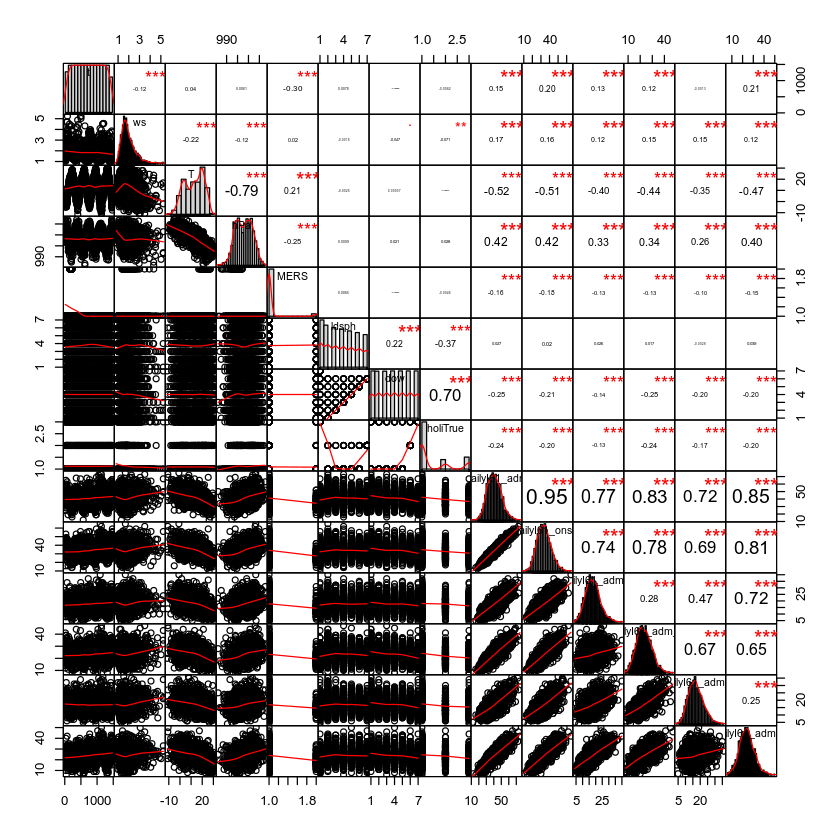

In [22]:
I61 <- df[, c('t', 'ws', 'T', 'hPa', 'MERS', 'ldsph', 'dow', 'holiTrue', 
             'dailyI61_adm', 'dailyI61_onset', 'dailyI61_adm_F', 
             'dailyI61_adm_M', 'dailyI61_adm_Y', 'dailyI61_adm_O')]
categorical_vars <- c('MERS', 'ldsph', 'dow', 'holiTrue')
I61[,categorical_vars] <- lapply(I61[, categorical_vars], as.numeric)
chart.Correlation(I61, histogram=TRUE, pch=1, cex.cor.scale=0)

We only include 
 - 't', 'ws', 'T', 'MERS', 'ldsph', 'dow'

In [23]:
cnt <- 1
resultsI61 <- data.frame()
for (y in c('dailyI61_adm', 'dailyI61_onset', 'dailyI61_adm_F', 
             'dailyI61_adm_M', 'dailyI61_adm_Y', 'dailyI61_adm_O')) {
    for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
        for (interval in c("lm1", "", "l1", "l2", "l3", "l4", "l5", "l6", "l7")) {
            if (is.na(interval) || interval == '') {
                var = ap
            }
            else {
                var = paste(ap, interval, sep="")
            }
        
            formula <- as.formula(sprintf("%s ~ %s + s(t) + s(T) + s(ws) + 
                                                MERS + ldsph + dow", y, var))
            model <- gam(formula = formula, data=df, method="REML", family=nb())
            rho <- exp(coef(model)[var]*1)
            ci <- exp(confint.default(model, var)*1)
            resultsI61[cnt, 1] <- y
            resultsI61[cnt, 2] <- var
            resultsI61[cnt, 3] <- exp(confint.default(model)[2,1]*iqr[[ap]])
            resultsI61[cnt, 4] <- exp(model$coefficients[2]*iqr[[ap]])
            resultsI61[cnt, 5] <- exp(confint.default(model)[2,2]*iqr[[ap]])
            cnt <- cnt + 1
        }
    }
}

In [24]:
names(resultsI61)[names(resultsI61) == 'V1'] <- 'Outcome'
names(resultsI61)[names(resultsI61) == 'V2'] <- 'predictor'
names(resultsI61)[names(resultsI61) == 'V3'] <- 'lwr'
names(resultsI61)[names(resultsI61) == 'V4'] <- 'mean'
names(resultsI61)[names(resultsI61) == 'V5'] <- 'upr'

resultsI61['stats'] <- ifelse(resultsI61['lwr'] >= 1 & resultsI61['upr'] >= 1, '+', '')
resultsI61[resultsI61[,'stats']=='+', ]

,Outcome,predictor,lwr,mean,upr,stats
20,dailyI61_adm,O3,1.000303,1.017499,1.034991,+
21,dailyI61_adm,O3l1,1.000533,1.016205,1.032122,+
23,dailyI61_adm,O3l3,1.000681,1.016839,1.033257,+
45,dailyI61_adm,PM10l7,1.001443,1.011369,1.021393,+
74,dailyI61_onset,O3,1.000826,1.019075,1.037656,+
75,dailyI61_onset,O3l1,1.000209,1.016803,1.033672,+
99,dailyI61_onset,PM10l7,1.000685,1.011155,1.021735,+
129,dailyI61_adm_F,O3l1,1.001048,1.025468,1.050483,+
133,dailyI61_adm_F,O3l5,1.003825,1.029487,1.055805,+
135,dailyI61_adm_F,O3l7,1.001872,1.027976,1.054761,+


In [25]:
resultsI61['stats'] <- ifelse(resultsI61['lwr'] < 1 & resultsI61['upr'] < 1, '-', '')
resultsI61[resultsI61[,'stats']=='-', ]

,Outcome,predictor,lwr,mean,upr,stats
3,dailyI61_adm,SO2l1,0.9647949,0.9780892,0.9915667,-
4,dailyI61_adm,SO2l2,0.9671521,0.9805034,0.9940390,-
5,dailyI61_adm,SO2l3,0.9729449,0.9863406,0.9999207,-
11,dailyI61_adm,CO,0.9637839,0.9812094,0.9989498,-
12,dailyI61_adm,COl1,0.9591266,0.9730894,0.9872555,-
13,dailyI61_adm,COl2,0.9582278,0.9718681,0.9857026,-
14,dailyI61_adm,COl3,0.9660880,0.9800166,0.9941459,-
30,dailyI61_adm,NO2l1,0.9549706,0.9700705,0.9854091,-
31,dailyI61_adm,NO2l2,0.9649744,0.9795905,0.9944280,-
32,dailyI61_adm,NO2l3,0.9703166,0.9850218,0.9999499,-


In [26]:
cnt_outcome <- 1
num_panel <- c('a', 'b', 'c', 'd', 'e', 'f')
outcome_names <- c('Nation-wide I61 daily E.R. adm.', 'Nation-wide I61 daily E.R. onset',
                   'Female I61 daily E.R. adm.', 'Male I61 daily E.R. adm.', 
                   '60– I61 daily E.R. adm.', '60+= I61 daily E.R. adm.')

ap_str <- c("$SO_2$", "$CO$", "$O_3$", "$NO_2$", "$PM_{10}$", "$PM_{2.5}$")
for (y in c('dailyI61_adm', 'dailyI61_onset', 'dailyI61_adm_F', 
             'dailyI61_adm_M', 'dailyI61_adm_Y', 'dailyI61_adm_O')) {

    plt_list = list()
    cnt_ap <- 1
    for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
        tmp <- resultsI61[resultsI61['Outcome'] == y, ]
        df_ap <- tmp[grep(ap, tmp$predictor), ]
        df_ap['Lag'] <- c('L–1', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7')
        plt <- ggplot(df_ap, aes(x = Lag, y = mean)) +
               geom_point(show.legend=T, size=0.7, 
                         position=position_dodge(width=0.3)) +
               geom_errorbar(data=df_ap, size=0.3, 
                            aes(ymin=lwr, ymax=upr, width=.3),
                               position=position_dodge(width=0.3)) +
               geom_hline(yintercept=1, linetype="longdash", size=0.3) +
               ggtitle(TeX(paste(paste(num_panel[[cnt_ap]], 
                                   outcome_names[[cnt_outcome]], sep=". "), 
                             ap_str[[cnt_ap]], sep=" ~ ")))+
               ylab("Excess rate")+
               scale_x_discrete(name=TeX(ap_str[[cnt_ap]])) +
               theme(plot.title=element_text(size=9, face="bold"),
                    axis.title.x=element_text(size=9, color="black"),
                    axis.title.y=element_text(size=9, color="black"),
                    axis.text.x=element_text(size=9, color="black"),
                    axis.text.y=element_text(size=9, color="black"),
                    legend.text = element_text(size=9),
                    legend.key=element_rect(fill=NA),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    axis.line = element_line(size=0.4, colour = "black"))
         plt_list[[cnt_ap]] <- plt            
         cnt_ap <- cnt_ap + 1
    }
    
    ggsave(paste(gsub(" ","_", outcome_names[[cnt_outcome]]), "png", sep="."),
           multiplot(plt_list[[1]], plt_list[[2]], plt_list[[3]], 
           plt_list[[4]], plt_list[[5]], plt_list[[6]], cols=2))
    cnt_outcome <- cnt_outcome + 1
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### Association between I63 and 6 air pollutants
1. We should select control variables by univariable association
2. Generalized additive model of negative binomial with estimating hyperparameter, theta 

In [27]:
results <- data.frame()
cnt <- 1
for (var in c('T', 'H', 'precip', 'ws', 'hPa', 'T_DdiffT', 'MERS', 
              'dow', 'mon', 't', 'holiTrue', 'ldsph')) {
    formula <- as.formula(sprintf("dailyI63_adm ~ %s", var))
    model <- gam(formula = formula, data=df, method="REML", family=nb())
    rho <- exp(coef(model)[var]*1)
    ci <- exp(confint.default(model, var)*1)
    #resultsI60[cnt, 1] <- y
    results[cnt, 1] <- var
    results[cnt, 2] <- confint.default(model)[2,1]
    results[cnt, 3] <- model$coefficients[2]
    results[cnt, 4] <- confint.default(model)[2,2]
    cnt <- cnt + 1
}

In [28]:
names(results)[names(results) == 'V1'] <- 'predictor'
names(results)[names(results) == 'V2'] <- 'lwr'
names(results)[names(results) == 'V3'] <- 'mean'
names(results)[names(results) == 'V4'] <- 'upr'

results['stats'] <- ifelse(results['lwr'] >= 0 & results['upr'] >= 0, '+', '')
results[results[,'stats'] == '+', ]

,predictor,lwr,mean,upr,stats
1,T,0.0007233227,0.0014114467,0.0020995706,+
6,T_DdiffT,0.0011812521,0.0034511847,0.0057211174,+
10,t,0.0001407539,0.0001548427,0.0001689316,+
12,ldsph,0.1973532250,0.2177638008,0.2381743766,+


In [29]:
results['stats'] <- ifelse(results['lwr'] < 0 & results['upr'] < 0, '-', '')
results[results[,'stats'] == '-', ]

,predictor,lwr,mean,upr,stats
4,ws,-0.03392813,-0.02368947,-0.01345081,-
7,MERS,-0.19288904,-0.16103944,-0.12918985,-
8,dow,-0.13881556,-0.11717084,-0.09552611,-
11,holiTrue,-0.09909793,-0.08023690,-0.06137587,-


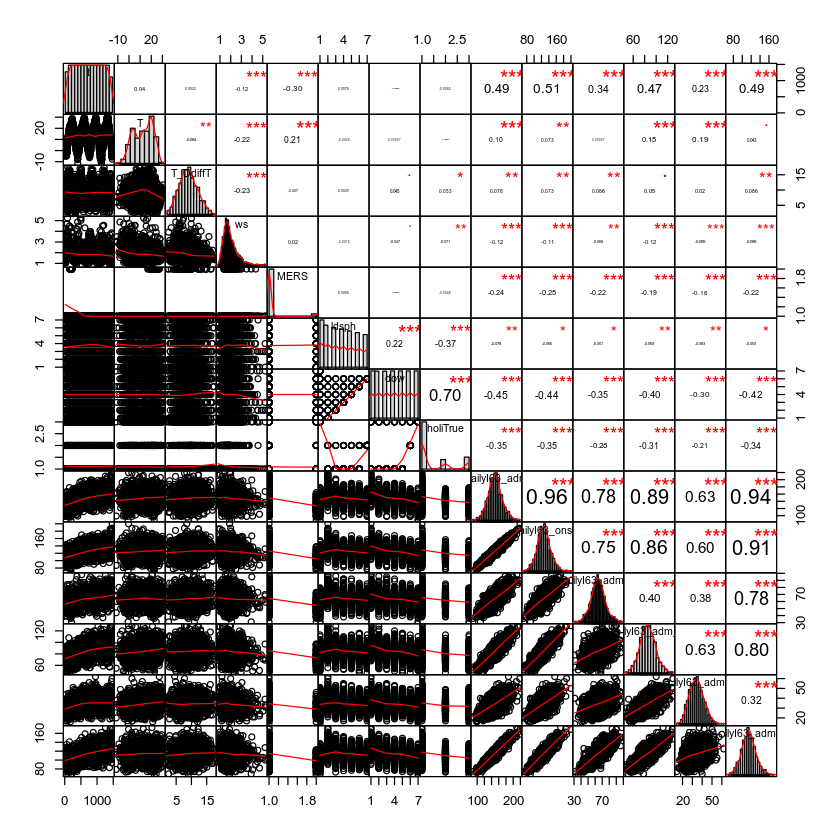

In [30]:
I63 <- df[, c('t', 'T', 'T_DdiffT', 'ws', 'MERS', 'ldsph', 'dow', 'holiTrue', 
             'dailyI63_adm', 'dailyI63_onset', 'dailyI63_adm_F', 
             'dailyI63_adm_M', 'dailyI63_adm_Y', 'dailyI63_adm_O')]
categorical_vars <- c('MERS', 'ldsph', 'dow', 'holiTrue')
I63[,categorical_vars] <- lapply(I63[, categorical_vars], as.numeric)
chart.Correlation(I63, histogram=TRUE, pch=1, cex.cor.scale=0)

We only include 
 - 't', 'T', 'T_DdiffT', 'ws', 'MERS', 'ldsph', 'dow', 'holiTrue'

In [31]:
# model <- gam(dailyI63_adm ~ s(t) + PM25 + MERS + mon + dow + holiTrue, data = df, method="REML", family =  nb())
# summary(model)
# par(mfrow=c(2,1))
# plot(residuals(model), type="b")
# abline(h=0, lty=3)
# acf(residuals(model), lag=365)
# par(mfrow=c(2,4))
# plot(model, residuals=TRUE, pages=1, pch=1,shade=TRUE,all.terms=TRUE,
#     seWithMean = TRUE,shift=coef(model)[1], cex=0.5)
# gam.check(model)
# plot(model, select=2, shade = TRUE, scale = 0, seWithMean = TRUE)

In [32]:
cnt <- 1
resultsI63 <- data.frame()
for (y in c('dailyI63_adm', 'dailyI63_onset', 'dailyI63_adm_F', 
             'dailyI63_adm_M', 'dailyI63_adm_Y', 'dailyI63_adm_O')) {
    for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
        for (interval in c("lm1", "", "l1", "l2", "l3", "l4", "l5", "l6", "l7")) {
            if (is.na(interval) || interval == '') {
                var = ap
            }
            else {
                var = paste(ap, interval, sep="")
            }
        
            formula <- as.formula(sprintf("%s ~ %s + s(t) + s(T) + s(T_DdiffT) + s(ws) +
                                                MERS + ldsph + dow", y, var))

            model <- gam(formula = formula, data=df, method="REML", family=nb())
            rho <- exp(coef(model)[var]*1)
            ci <- exp(confint.default(model, var)*1)
            resultsI63[cnt, 1] <- y
            resultsI63[cnt, 2] <- var
            resultsI63[cnt, 3] <- exp(confint.default(model)[2,1]*iqr[[ap]])
            resultsI63[cnt, 4] <- exp(model$coefficients[2]*iqr[[ap]])
            resultsI63[cnt, 5] <- exp(confint.default(model)[2,2]*iqr[[ap]])
            cnt <- cnt + 1
            print(resultsI63)
        }
    }
}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
names(resultsI63)[names(resultsI63) == 'V1'] <- 'Outcome'
names(resultsI63)[names(resultsI63) == 'V2'] <- 'predictor'
names(resultsI63)[names(resultsI63) == 'V3'] <- 'lwr'
names(resultsI63)[names(resultsI63) == 'V4'] <- 'mean'
names(resultsI63)[names(resultsI63) == 'V5'] <- 'upr'
resultsI63['stats'] <- ifelse(resultsI63['lwr'] >= 1 & resultsI63['upr'] >= 1, '+', '')
resultsI63[resultsI63[,'stats']=='+', ]

,Outcome,predictor,lwr,mean,upr,stats
1,dailyI63_adm,SO2lm1,1.004187,1.013074,1.022040,+
42,dailyI63_adm,PM10l4,1.000140,1.005349,1.010585,+
43,dailyI63_adm,PM10l5,1.001556,1.006763,1.011997,+
52,dailyI63_adm,PM25l5,1.000667,1.006970,1.013312,+
53,dailyI63_adm,PM25l6,1.001272,1.007559,1.013886,+
55,dailyI63_onset,SO2lm1,1.002953,1.012186,1.021505,+
62,dailyI63_onset,SO2l6,1.000718,1.008415,1.016171,+
65,dailyI63_onset,CO,1.000319,1.009980,1.019734,+
71,dailyI63_onset,COl6,1.002604,1.010998,1.019462,+
89,dailyI63_onset,NO2l6,1.001108,1.009706,1.018377,+


In [34]:
resultsI63['stats'] <- ifelse(resultsI63['lwr'] < 1 & resultsI63['upr'] < 1, '-', '')
resultsI63[resultsI63[,'stats']=='-', ]

,Outcome,predictor,lwr,mean,upr,stats
135,dailyI63_adm_F,O3l7,0.9711717,0.9834934,0.9959714,-
219,dailyI63_adm_Y,SO2l1,0.9681208,0.9827235,0.9975464,-
220,dailyI63_adm_Y,SO2l2,0.9659137,0.9804097,0.9951231,-
229,dailyI63_adm_Y,COl2,0.9650566,0.9799648,0.9951033,-
246,dailyI63_adm_Y,NO2l1,0.9617746,0.9772326,0.9929391,-
247,dailyI63_adm_Y,NO2l2,0.9621879,0.9775832,0.9932250,-
248,dailyI63_adm_Y,NO2l3,0.9627141,0.9784192,0.9943804,-
255,dailyI63_adm_Y,PM10l1,0.9767436,0.9875105,0.9983962,-


In [35]:
cnt_outcome <- 1
num_panel <- c('a', 'b', 'c', 'd', 'e', 'f')
outcome_names <- c('Nation-wide I63 daily E.R. adm.', 'Nation-wide I63 daily E.R. onset',
                   'Female I63 daily E.R. adm.', 'Male I63 daily E.R. adm.', 
                   '60– I63 daily E.R. adm.', '60+= I63 daily E.R. adm.')

ap_str <- c("$SO_2$", "$CO$", "$O_3$", "$NO_2$", "$PM_{10}$", "$PM_{2.5}$")
for (y in c('dailyI63_adm', 'dailyI63_onset', 'dailyI63_adm_F', 
             'dailyI63_adm_M', 'dailyI63_adm_Y', 'dailyI63_adm_O')) {

    plt_list = list()
    cnt_ap <- 1
    for (ap in c("SO2", "CO", "O3", "NO2", "PM10", "PM25")) {
        tmp <- resultsI63[resultsI63['Outcome'] == y, ]
        df_ap <- tmp[grep(ap, tmp$predictor), ]
        df_ap['Lag'] <- c('L–1', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7')
        plt <- ggplot(df_ap, aes(x = Lag, y = mean)) +
               geom_point(show.legend=T, size=0.7, 
                         position=position_dodge(width=0.3)) +
               geom_errorbar(data=df_ap, size=0.3, 
                            aes(ymin=lwr, ymax=upr, width=.3),
                               position=position_dodge(width=0.3)) +
               geom_hline(yintercept=1, linetype="longdash", size=0.3) +
               ggtitle(TeX(paste(paste(num_panel[[cnt_ap]], 
                                   outcome_names[[cnt_outcome]], sep=". "), 
                             ap_str[[cnt_ap]], sep=" ~ ")))+
               ylab("Excess rate")+
               scale_x_discrete(name=TeX(ap_str[[cnt_ap]])) +
               theme(plot.title=element_text(size=9, face="bold"),
                    axis.title.x=element_text(size=9, color="black"),
                    axis.title.y=element_text(size=9, color="black"),
                    axis.text.x=element_text(size=9, color="black"),
                    axis.text.y=element_text(size=9, color="black"),
                    legend.text = element_text(size=9),
                    legend.key=element_rect(fill=NA),
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(),
                    panel.background = element_blank(),
                    axis.line = element_line(size=0.4, colour = "black"))
         plt_list[[cnt_ap]] <- plt            
         cnt_ap <- cnt_ap + 1
    }
    
    ggsave(paste(gsub(" ","_", outcome_names[[cnt_outcome]]), "png", sep="."),
           multiplot(plt_list[[1]], plt_list[[2]], plt_list[[3]], 
           plt_list[[4]], plt_list[[5]], plt_list[[6]], cols=2))
    cnt_outcome <- cnt_outcome + 1
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
